## Clustering on C50 (Breast Cancer) Pathology Notes
*Author: Matthew Rossi*

### Imports and Helper Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD

In [2]:
def fetch_subset(data, code, mode='include'):
    """
        data is a pandas table with the following columns: 'c.icd10_after_spilt', 'c.path_notes'
        code is the icd10 code to be included/excluded in the new dataset
        mode indicates whether to include or exclude entries with the specified icd10code

        ex. fetch_subset(data, "C50", mode='include') returns all entries whose icd10 codes contain C50
        fetch_subset(data, "C50.9", mode='exclude') returns all entries that don't contain C50.9
    """
    if mode == 'include':
        return data[data['c.icd10_after_spilt'].str.contains(code)]
    if mode == 'exclude':
        return data[data['c.icd10_after_spilt'].str.contains(code) == False]

In [3]:
def process_text(text):
    text = text.lower()
    text = re.sub("dr\.",'dr', text)
    text = re.sub('m\.d\.', 'md', text)
    text = re.sub('a\.m\.','am', text)
    text = re.sub('p\.m\.','pm', text)
    text = re.sub("\d+\.\d+", 'floattoken', text)
    text = re.sub("\.{2,}", '.', text)
    text = re.sub('[^\w_|\.|\?|!]+', ' ', text)
    text = re.sub('\.', ' . ', text)
    text = re.sub('\?', ' ? ', text)
    text = re.sub('!', ' ! ', text)
    text = re.sub('\d{3,}', '', text)
    return text

In [4]:
def getvocabcounts(data, outfile):
    docno = 1
    counts = {}
    num_docs = len(data['c.path_notes'])
    for doc in data['c.path_notes']:
        sys.stdout.write("processing/counting doc %i of %i                \r" % (docno, num_docs))
        sys.stdout.flush()
        text = process_text(doc)
        
        for word in text.split():
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
        
        docno += 1
        
    dct = {
        'word' : list(counts.keys()),
        'count' : list(counts.values())
    }
    countspd = pd.DataFrame(dct).sort_values(by='count', ascending=False)
    countspd.to_csv(outfile, sep='\t', index=False)

### Data Preparation

Read in the whole dataset, discard patient IDs, and fetch the C50 subset.

In [5]:
data = pd.read_csv("../data/icd10notes.txt","\t")
data = data.drop('c.reident_key', axis=1)
c50_data = fetch_subset(data, "C50", mode='include')
print("Number of datapoints in new subset:", len(c50_data))

Number of datapoints in new subset: 16791


Count the word frequencies in the dataset:

In [6]:
getvocabcounts(c50_data, "../data/c50vocabfreq.txt")

View the label distribution in the full c50 dataset:

In [7]:
labels = list(c50_data['c.icd10_after_spilt'])
sitelabels = []
for label in labels:
    sitelabels.append(int(label[4]))
    
MFlabels = []
for label in labels:
    MFlabels.append(int(label[5]))
    
LRUlabels = []
for label in labels:
    LRUlabels.append(int(label[6]))

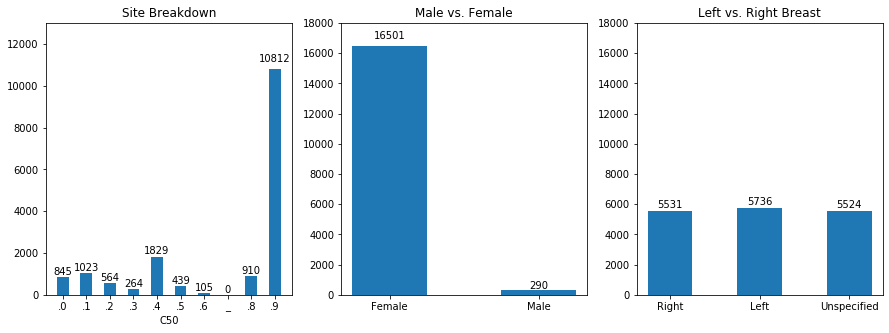

In [8]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
width = 0.5

counts = np.bincount(sitelabels)
ind = np.arange(len(counts))
rects0 = axs[0].bar(ind, counts, width)
axs[0].set_title("Site Breakdown")
axs[0].set_xlabel("C50")
axs[0].set_xticks(ind)
axs[0].set_xticklabels(('.0','.1','.2','.3','.4',
                        '.5','.6','_' ,'.8','.9'))
axs[0].set_ylim(top=13000)

counts = np.bincount(MFlabels)[1:]
ind = np.arange(len(counts))
rects1 = axs[1].bar(ind, counts, width)
axs[1].set_title("Male vs. Female")
axs[1].set_xticks(ind)
axs[1].set_xticklabels(('Female', 'Male'))
axs[1].set_ylim(top=18000)

counts = np.bincount(LRUlabels)[np.where(np.bincount(LRUlabels) != 0)]
ind = np.arange(len(counts))
rects2 = axs[2].bar(ind, counts, width)
axs[2].set_title("Left vs. Right Breast")
axs[2].set_xticks(ind)
axs[2].set_xticklabels(('Right', 'Left', 'Unspecified'))
axs[2].set_ylim(top=18000)

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%d' % int(height),
                ha='center', va='bottom')
        
autolabel(rects0, axs[0])
autolabel(rects1, axs[1])
autolabel(rects2, axs[2])


fig.savefig("../graphics/c50_hists.eps")

C50 Code Details:

    C50.0: Malignant neoplasm of nipple and areola  
    C50.1: Malignant neoplasm of central portion of breast  
    C50.2: Malignant neoplasm of upper-inner quadrant of breast  
    C50.3: Malignant neoplasm of lower-inner quadrant of breast  
    C50.4: Malignant neoplasm of upper-outer quadrant of breast  
    C50.5: Malignant neoplasm of lower-outer quadrant of breast  
    C50.6: Malignant neoplasm of axillary tail of breast  
    C50.8: Malignant neoplasm of overlapping sites of breast  
    C50.9: Malignant neoplasm of breast of unspecified site    
    
    C50.X1: Female  
    C50.X2: Male    
    
    C50.XX1: Right breast  
    C50.XX2: Left breast  
    C50.XX9: Unspecified breast

The majority of datapoints are C50.9XX, which indicates an unspecified site, while a third of datapoints are C50.XX9, which indicates that whether the tumor is in the left or right breast is unspecified.$$\\\\$$
Let's exclude the "unspecified site" datapoints and generate labels for the three different elements (site, M vs F, L vs R).

In [9]:
c50spfd_data = fetch_subset(c50_data, "C50.9", mode='exclude')
print(len(c50spfd_data))
labels = list(c50spfd_data['c.icd10_after_spilt'])
sitelabels = []
for label in labels:
    sitelabels.append(int(label[4]))
    
MFlabels = []
for label in labels:
    MFlabels.append(int(label[5]))
    
LRUlabels = []
for label in labels:
    LRUlabels.append(int(label[6]))

5979


Process the text using our helper function:

In [10]:
lineno = 1
docs = []
num_docs = len(c50spfd_data['c.path_notes'])
for line in c50spfd_data['c.path_notes']:
    sys.stdout.write("processing line %i of %i       \r" % (lineno, num_docs))
    sys.stdout.flush()
    text = process_text(line)
    docs.append(text)
    lineno+=1

### Vectorization and Clustering

In [11]:
stopwords = ["a", "an", "the", "and", "for", "that", "of", "outside", "out", "with", "in", "to", "these", "is", "are",
             "by", "x", "atient", "name", "mrn", "case", "report", "umhc", "comment", "s", "signed", "electronically", "note", 
             "p", "f", "m" "fellow", "clinical", "laboratory", "room", "uhealth", "pathology", "path", "client", "fax", 
             "phone", "telephone", "md", "dr", "phd", "mba", "pathologist", "attending", "i", "ii", "iii", "department", 
             "received", "sw", "nw", "name", "dob", "gender", "medical", "director", "demographics", "ave", "surgical", 
             "physician", "location", "final", "see", "description", "provided", "status", "ordered", "addendum", "patient", 
             "resident", "examination", "issuance", "involved", "history", "diagnosis", "release"]

Vectorize the list of documents so that they can be clustered:

In [12]:
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(docs)
print("Each document is represented with a sparse %i-dimensional vector." % X.shape[1])
print("Average number of nonzero elements per vector: %3.2f" % (len(X.data)/X.shape[1]))

Each document is represented with a sparse 11381-dimensional vector.
Average number of nonzero elements per vector: 128.49


Next, we apply clustering using the K-means algorithm on the vectorized dataset, letting the number of clusters vary from 1-100, tracking the loss for each execution of the algorithm.

In [13]:
scores = []
for n_clusters in range(1,100):
    sys.stdout.write("evaluating kmeans with %i clusters       \r" % (n_clusters))
    sys.stdout.flush()
    kmeans = MiniBatchKMeans(n_clusters, random_state=0, batch_size=1024)
    kmeans.fit(X)
    scores.append(-kmeans.score(X))

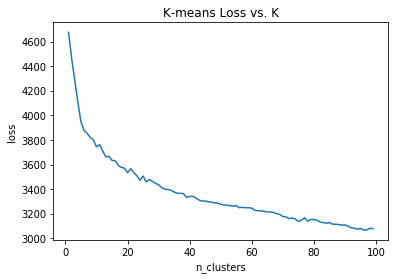

In [14]:
plt.plot(range(1,len(scores)+1),scores)
plt.xlabel("n_clusters")
plt.ylabel("loss")
plt.title("K-means Loss vs. K")
plt.savefig("../graphics/kmeans_loss.eps")

This type of curve is used to select an optimal value for K.  
However, this particular loss curve doesn't flatten out for a reasonable number of clusters, which indicates that either:  
> A. the data is too noisy; or  
B. the data does not contain natural clusters.

Reduce the vectorized dataset to 2 dimensions for visualization:

In [15]:
svd = TruncatedSVD(n_components=2)
X_new = svd.fit_transform(X)

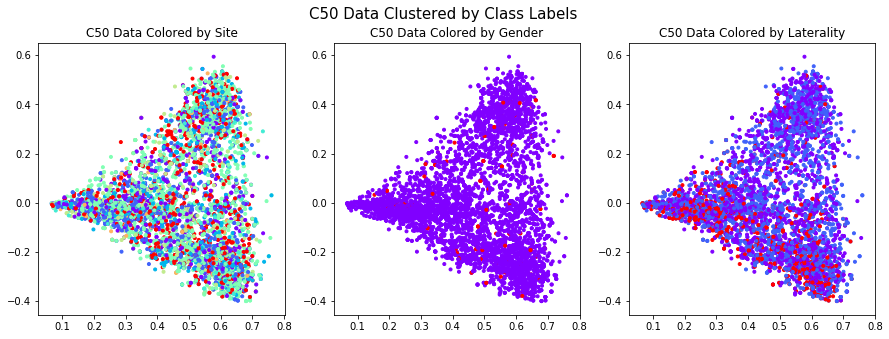

In [16]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("C50 Data Clustered by Class Labels", fontsize=15)

axs[0].scatter(X_new[:,0], X_new[:,1], marker='.', c=sitelabels, cmap='rainbow')
axs[0].set_title("C50 Data Colored by Site")

axs[1].scatter(X_new[:,0], X_new[:,1], marker='.', c=MFlabels, cmap='rainbow')
axs[1].set_title("C50 Data Colored by Gender")

axs[2].scatter(X_new[:,0], X_new[:,1], marker='.', c=LRUlabels, cmap='rainbow')
axs[2].set_title("C50 Data Colored by Laterality")

fig.savefig("../graphics/c50spfd_class_scatters.eps")

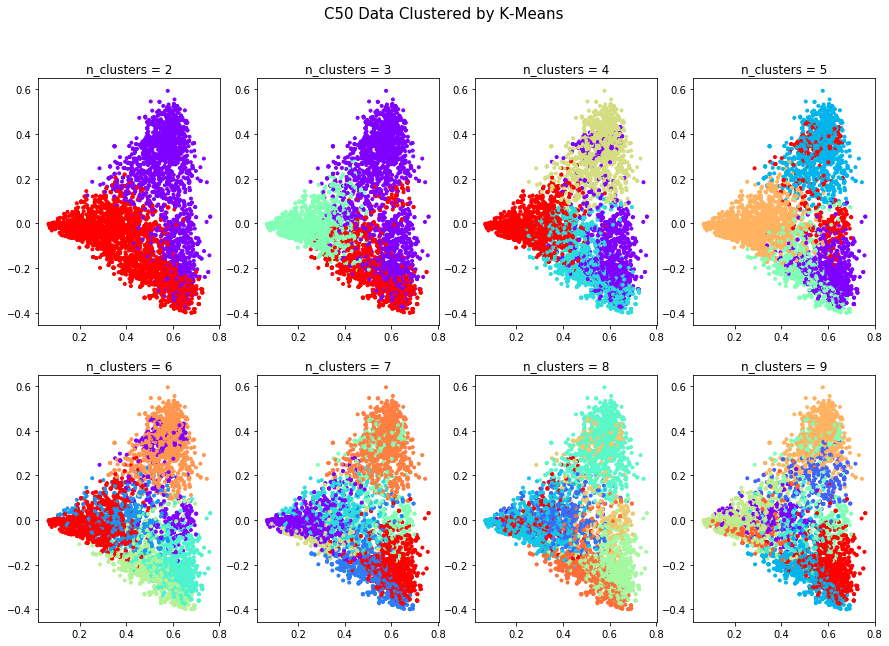

In [17]:
fig, axs = plt.subplots(2,4, figsize=(15,10))
fig.suptitle("C50 Data Clustered by K-Means", fontsize=15)

for i in range(0,4):
    n_clusters = i + 2
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0, batch_size=1024)
    y_pred = kmeans.fit_predict(X)
    axs[0][i].scatter(X_new[:,0], X_new[:,1], marker='.', c=y_pred, cmap='rainbow')
    axs[0][i].set_title("n_clusters = %i" % n_clusters)
for i in range(4,8):
    n_clusters = i + 2
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0, batch_size=1024)
    y_pred = kmeans.fit_predict(X)
    axs[1][i-4].scatter(X_new[:,0], X_new[:,1], marker='.', c=y_pred, cmap='rainbow')
    axs[1][i-4].set_title("n_clusters = %i" % n_clusters)
    
fig.savefig("../graphics/c50spfd_cluster_scatters.eps")

## Conclusion:
    Either:  
    A. The region of the vector space in which a document appears has no relationship with its ICD10 labels; or  
    B. The data is too noisy, even after preprocessing, to see such a relationship.    
    
Conclusion A does not necessarily mean that vector space based machine learning approaches cannot work: the relationships between points in the high-dimensional vector space may hold the data contained in the ICD10 labels. Supervised learning methods may have more success.